# Comprehensive Pancreas Data Analysis Pipeline

This notebook provides an end-to-end pipeline for pancreas data analysis:
- Data loading and preprocessing with multiple options
- HVG selection and validation
- Normalization and quality control
- Visualization and evaluation

## 1. Setup and Imports

In [12]:
import os
from pathlib import Path
import warnings
import scanpy as sc
import scib 
import numpy as np
import pandas as pd
import scipy.sparse
import scgpt as scg
import matplotlib.pyplot as plt
import seaborn as sns
from anndata._warnings import OldFormatWarning

# Suppress warnings
warnings.filterwarnings('ignore', category=OldFormatWarning)
warnings.filterwarnings('ignore', category=UserWarning)
plt.style.context('default')

## 2. Configuration and Directory Setup

In [13]:
def setup_directories():
    """Set up necessary directories and paths"""
    repo_dir = Path.cwd().parent.absolute()
    data_dir = repo_dir / "data"
    save_dir = repo_dir / "save"
    
    # Create directories if they don't exist
    data_dir.mkdir(parents=True, exist_ok=True)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    return repo_dir, data_dir, save_dir

# Set up configuration
config = {
    "file_path": "human_pancreas_norm_complexBatch.h5ad",
    "n_top_genes": 1800,
    "gene_col": "gene_name",
    "cell_type_key": "celltype",
    "batch_key": "tech",
    "normalize_total": 1e4,
    "binning": 10,
    "use_hvg": True
}

# Set up directories
repo_dir, data_dir, save_dir = setup_directories()
print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Save directory: {save_dir}")

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Data directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data
Save directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save


In [14]:
file_path = data_dir / config["file_path"]
print (file_path)

c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data\human_pancreas_norm_complexBatch.h5ad


## 3. Data Loading Functions

In [15]:
def load_data_scanpy(file_path, n_top_genes=1800, hvg=True, show_info=True):
    """Load and preprocess data using scanpy pipeline"""
    adata = sc.read_h5ad(file_path)
    
    # HVG selection if requested
    if hvg and 'highly_variable' not in adata.var.columns:
        sc.pp.highly_variable_genes(
            adata, 
            n_top_genes=n_top_genes, 
            flavor='seurat_v3'
        )
        adata = adata[:, adata.var['highly_variable']]
    
    # Check and perform normalization if needed
    if adata.X.max() > 10:
        print("Performing normalization...")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    else:
        print("Data appears to be already normalized")
    
    if show_info:
        print_data_info(adata)
    
    return adata

def load_data_scgpt(file_path, config):
    """Load and preprocess data using scGPT pipeline"""
    adata = sc.read_h5ad(file_path)
    
    preprocessor = scg.preprocess.Preprocessor(
        use_key="X",
        filter_gene_by_counts=10,
        filter_cell_by_counts=10,
        normalize_total=config["normalize_total"],
        result_normed_key="X_normed",
        log1p=True,
        result_log1p_key="X_log1p",
        subset_hvg=config["use_hvg"],
        hvg_flavor="seurat_v3",
        binning=config["binning"],
        result_binned_key="X_binned",
    )
    
    preprocessor(adata, batch_key=config["batch_key"])
    return adata

## 4. Quality Control and Validation Functions

In [16]:
def print_data_info(adata):
    """Print comprehensive information about the AnnData object"""
    print("\n=== Data Information ===")
    print(f"AnnData object: {adata}")
    print(f"Shape: {adata.shape}")
    
    # Matrix information
    print("\nMatrix Information:")
    print(f"X storage type: {type(adata.X)}")
    if scipy.sparse.issparse(adata.X):
        print("Sparse matrix details:")
        print(f"- data shape: {adata.X.data.shape}")
        print(f"- indices shape: {adata.X.indices.shape}")
        print(f"- indptr shape: {adata.X.indptr.shape}")
    
    # Content information
    print("\nAvailable annotations:")
    print(f"Observations (obs): {adata.obs.columns.tolist()}")
    print(f"Variables (var): {adata.var.columns.tolist()}")
    
    if 'highly_variable' in adata.var.columns:
        n_hvg = adata.var['highly_variable'].sum()
        print(f"\nHVG Information:")
        print(f"Number of highly variable genes: {n_hvg}")

def validate_preprocessing(adata):
    """Validate the preprocessing steps"""
    checks = {
        "Size": adata.n_obs > 0 and adata.n_vars > 0,
        "Normalization": adata.X.max() <= 10,
        "Annotations": all(key in adata.obs.columns for key in ['tech', 'celltype']),
        "HVG": 'highly_variable' in adata.var.columns if config["use_hvg"] else True
    }
    
    print("\n=== Validation Results ===")
    for check, result in checks.items():
        print(f"{check}: {'✓' if result else '✗'}")
    
    return all(checks.values())

## 5. Load and Process Data

In [18]:
adata = sc.read(file_path)

In [ ]:
# Load the data
file_path = data_dir / config["file_path"]
print("Loading and processing data...")

try:
    # Try scGPT preprocessing first
    adata = load_data_scgpt(file_path, config)
    print("Successfully used scGPT preprocessing")
except Exception as e:
    print(f"scGPT preprocessing failed: {e}")
    print("Falling back to scanpy preprocessing...")
    adata = load_data_scanpy(file_path, config["n_top_genes"])

# Validate the preprocessing


Loading and processing data...
scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - WARNING - The input data seems to be already log1p transformed. Set `log1p=False` to avoid double log1p transform.
scGPT - INFO - Subsetting highly variable genes ...
scGPT preprocessing failed: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
Falling back to scanpy preprocessing...


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 6. Visualization

<Figure size 1000x800 with 0 Axes>

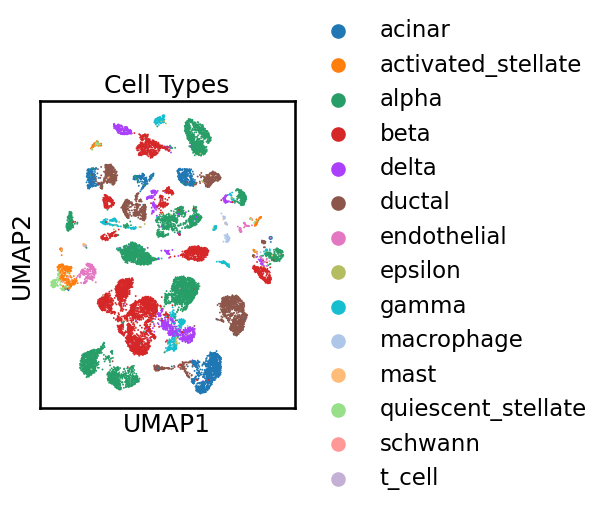

<Figure size 1000x800 with 0 Axes>

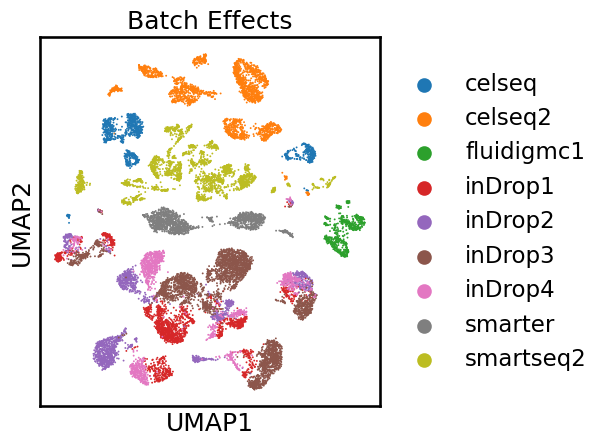

In [19]:
def create_visualizations(adata):
    """Create and display visualizations"""
    # UMAP visualization
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    
    # Cell type UMAP
    plt.figure(figsize=(10, 8))
    sc.pl.umap(adata, color='celltype', title='Cell Types', show=False)
    plt.tight_layout()
    plt.show()
    
    # Batch effect UMAP
    plt.figure(figsize=(10, 8))
    sc.pl.umap(adata, color='tech', title='Batch Effects', show=False)
    plt.tight_layout()
    plt.show()
    
    # Gene expression visualization if HVG is available
    if 'highly_variable' in adata.var.columns:
        plt.figure(figsize=(12, 6))
        sc.pl.highly_variable_genes(adata, show=False)
        plt.tight_layout()
        plt.show()

# Create visualizations
create_visualizations(adata)

## 7. Save Processed Data

In [ ]:
# Save the processed data
processed_path = save_processed_data(adata, save_dir, config)
print("Analysis pipeline completed successfully!")